**Data Preparing for Building a Dashboard with Google Looker Studio**

**Introduction**

---
In this project, I will create visualizations using the 2024 Stack Overflow survey dataset and add them to dashboards in Google Looker Studio.

**Software used in this project**

---
*   Google's CoLab
*   Google's Looker Studio

**Prerequisites**

---
You need access to Google Looker studio. This Google Looker studio project
will guide to get your access to Google Looker studio, and also get you started with how to useit to analyze the data.

**Dataset used in this assignment**


---
The data set used in this assignment is the Stack Overflow Developer Survey data is available at:
https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HLOosvsPgIwt5dgOOh1RSg/survey-data-updated.csv

We are using a modified subset of that data set for the assignment, so to follow the assigment instructions successfully, please use the data set provided with theassignment, rather than the data set from the original source.

### **Part 1 - Data Wrangling**


---
*   Input csv data
*   To verify data
*   Data Cleaning by IQR
*   To Extract data for particular purpose
*   To Get ready for Part 2 - Building Dashboard

In [ ]:
# Import libraries
!pip install pandas               # Install pandas for data manipulation and analysis
!pip install matplotlib           # Install matplotlib for plotting and visualizations
!pip install rapidfuzz            # Install rapidfuzz for fast and flexible string matching
!pip install seaborn              # Install seaborn for statistical data visualization
!pip install squarify             # Install squarify for treemap visualizations


import pandas as pd               # For data manipulation and analysis
import matplotlib.pyplot as plt   # For creating static visualizations
import seaborn as sns             # For statistical data visualization with enhanced aesthetics
import numpy as np                # For numerical operations and array handling
import unicodedata                # For Unicode character normalization and handling
import re                         # For regular expressions and pattern matching
import sqlite3                    # import SQLite database
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported
import os
import plotly.express as px

from rapidfuzz import process     # Import 'process' for extracting best string matches from a list
from collections import Counter
from wordcloud import WordCloud
from collections import Counter # Import Counter for word frequency
from google.colab import files

print("="*30)
print("Lib packages installed")
print("="*30)

Lib packages installed


In [ ]:
# Displays value counts for a specified column in the DataFrame.
def show_value_counts(df, chk_col):  #df: dataframe, chk_col: column name
    if chk_col in df.columns:
        return df[chk_col].value_counts(dropna=False)  # return counts
    else:
        raise ValueError(f"Column '{chk_col}' not found in DataFrame.")

In [ ]:
# Apply IQR method to remove outliers
def drop_iqr_outliers(df, column, multiplier=1.5):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[column]):
        raise TypeError(f"Column '{column}' must be numeric.")

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR

    return df[df[column].between(lower_bound, upper_bound)].copy()

In [ ]:
def create_grouped_boxplot(df, value_column, group_column, cht_width=6, cht_height=4):
    """
    Generates a box plot for a specified value column, grouped by a categorical column.
    If group_column is 'all', all data will be treated as one group for the boxplot.
    All aesthetic attributes are controlled internally.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - value_column (str): The name of the column for which to plot the distribution (y-axis).
    - group_column (str): The name of the column to group by (x-axis). If 'all', no grouping is applied.
    """

    # --- Internal control of aesthetic attributes ---
    figsize = (cht_width, cht_height) # Use user-provided or default width and height
    style = 'whitegrid'
    showfliers = True
    notch = False
    linewidth = 1.5
    rotation = 45 # Rotate x-axis labels if there are many groups
    grid = True

    # Default properties for median, mean, whisker, cap
    medianprops = {'color': 'red', 'linewidth': 2}
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'blue', 'markersize': 8}
    whiskerprops = {'color': 'gray', 'linewidth': 1.5}
    capprops = {'color': 'gray', 'linewidth': 1.5}

    plt.figure(figsize=figsize)
    ax = plt.gca()

    sns.set_style(style)

    if group_column == 'all':
        # Plot single box plot for all data
        plot_x = None
        plot_y = value_column
        plot_hue = None
        plot_legend = False # No legend needed for a single box
        plot_palette = None # No palette needed for a single box
        title = f'Distribution of {value_column} (All Data)'
        xlabel = ''
        ylabel = value_column
    else:
        # Plot grouped box plot
        plot_x = group_column
        plot_y = value_column
        plot_hue = group_column # Assign x variable to hue to resolve FutureWarning
        plot_legend = False # Set legend to False as per FutureWarning suggestion
        plot_palette = 'viridis' # Use a color palette for different groups on the x-axis
        title = f'Distribution of {value_column} by {group_column}'
        xlabel = group_column
        ylabel = value_column

    sns.boxplot(
        x=plot_x,
        y=plot_y,
        data=df,
        ax=ax,
        showfliers=showfliers,
        width=0.7, # Slightly narrower boxes for better spacing
        notch=notch,
        linewidth=linewidth,
        medianprops=medianprops,
        meanprops=meanprops,
        whiskerprops=whiskerprops,
        capprops=capprops,
        showmeans=True, # Always show mean with predefined properties
        orient='v',
        hue=plot_hue,
        palette=plot_palette,
        legend=plot_legend
    )

    ax.set_title(title, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)

    # Apply tick font sizes
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    if rotation != 0 and group_column != 'all': # Only rotate if there are actual groups
        plt.xticks(rotation=rotation, ha='right') # Rotate and align labels right

    if grid:
        ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [ ]:
# Load the data

url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HLOosvsPgIwt5dgOOh1RSg/survey-data-updated.csv'
df = pd.read_csv(url)

# Display the first few rows to understand the structure of the data
df.head(2)

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN


In [ ]:
# Basic Verification Package
print("Data Size")
print("-"*50)
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("-"*50)
print("\n\nTitle")
print("-"*50)
print(df.columns)
print("-"*50)
print("\n\nData Types")
print("-"*50)
print(df.dtypes)
print("-"*50)

Data Size
--------------------------------------------------
Rows: 18845
Columns: 114
--------------------------------------------------


Title
--------------------------------------------------
Index(['ResponseId', 'MainBranch', 'Age', 'Employment', 'RemoteWork', 'Check',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       ...
       'JobSatPoints_6', 'JobSatPoints_7', 'JobSatPoints_8', 'JobSatPoints_9',
       'JobSatPoints_10', 'JobSatPoints_11', 'SurveyLength', 'SurveyEase',
       'ConvertedCompYearly', 'JobSat'],
      dtype='object', length=114)
--------------------------------------------------


Data Types
--------------------------------------------------
ResponseId               int64
MainBranch              object
Age                     object
Employment              object
RemoteWork              object
                        ...   
JobSatPoints_11        float64
SurveyLength            object
SurveyEase              object
ConvertedCompYearly  

*   To clean data (dropna)
*   To remove outliers (IQR) if necessary
*   To handle missing data (fill by mean/median/other?) Let's check the data first.

### **Drop Duplicate Respondents**

# **Key Matric**


---
*   LanguageHaveWorkedWith
*   DatabaseHaveWorkedWith
*   PlatformHaveWorkedWith
*   WebframeHaveWorkedWith
---
*   LanguageWantToWorkWith
*   DatabaseWantToWorkWith
*   PlatformWantToWorkWith
*   WebframeWantToWorkWith
---
*   Respondent distribution by Age
*   Respondent Count by Country
*   Respondent distribution by Formal Edu Level
*   Respondent Count by Age, classified by Edu Level


In [ ]:
# Drop duplicates from Data Frame
print(f"Rows before dropping duplicates: {df.shape[0]}")
df.drop_duplicates(subset=['ResponseId'], inplace=True)
print(f"Rows after dropping duplicates: {df.shape[0]}")

Rows before dropping duplicates: 18845
Rows after dropping duplicates: 18845


In [ ]:
# Drop NaN from columns Age, Country, EdLevel
print(f"Rows before dropping NaN: {df.shape[0]}")
df.dropna(subset=['Age', 'Country', 'EdLevel'], inplace=True)
print(f"Rows after dropping NaN: {df.shape[0]}")

Rows before dropping NaN: 18845
Rows after dropping NaN: 18845


In [ ]:
print(show_value_counts(df, 'LanguageHaveWorkedWith'))

LanguageHaveWorkedWith
HTML/CSS;JavaScript;TypeScript                                             291
C#;HTML/CSS;JavaScript;SQL;TypeScript                                      240
HTML/CSS;JavaScript;PHP;SQL                                                196
C#;HTML/CSS;JavaScript;SQL                                                 152
HTML/CSS;JavaScript;SQL;TypeScript                                         131
                                                                          ... 
Bash/Shell (all shells);Groovy;Java;Kotlin                                   1
Bash/Shell (all shells);C;C++;PHP;Python;SQL                                 1
Bash/Shell (all shells);C;HTML/CSS;Python                                    1
Go;JavaScript;Ruby;Rust;SQL                                                  1
Bash/Shell (all shells);C;C#;C++;Java;JavaScript;Objective-C;Python;SQL      1
Name: count, Length: 9343, dtype: int64


In [ ]:
def extract_individual_delimited_items(df, column_name, delimiter=';'):
    """
    Extracts all individual items from a DataFrame column where items are delimited,
    returning them as a list of (ResponseId, item) tuples.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column_name (str): The name of the column containing the delimited items.
    - delimiter (str): The character used to separate items within each cell.

    Returns:
    - list: A list of (ResponseId, individual_item) tuples.
    """
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")

    if 'ResponseId' not in df.columns:
        raise ValueError("DataFrame must contain 'ResponseId' column to link items.")

    all_items_with_ids = []
    for index, row in df.iterrows():
        response_id = row['ResponseId']
        item_string = row[column_name]
        age_numeric = row['Age_numeric']
        JobSat=row['JobSat']

        if pd.notna(item_string):
            # Split by delimiter, strip whitespace, and filter out empty strings
            items = [item.strip() for item in str(item_string).split(delimiter) if item.strip()]
            for item in items:
                all_items_with_ids.append((response_id, item, age_numeric, JobSat))

    return all_items_with_ids

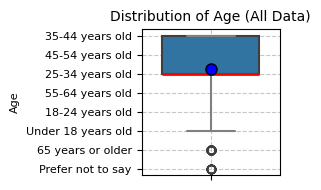

In [ ]:
# create boxplot for Age
create_grouped_boxplot(
    df=df,
    value_column='Age',
    group_column='all',
    cht_width=3,
    cht_height=2
)

In [ ]:
# check column Age
print(show_value_counts(df, 'Age'))

Age
25-34 years old       7788
35-44 years old       5149
18-24 years old       2988
45-54 years old       2053
55-64 years old        632
Under 18 years old     136
65 years or older       75
Prefer not to say       24
Name: count, dtype: int64


In [ ]:
# Age Grouping using median value
def map_age_group_to_numeric(age_group):
    """
    Maps an age group string to its numerical median value.
    Handles specific cases: 'Under 18 years old', '65 years or older', and 'Prefer not to say'.
    """
    if pd.isna(age_group): # Handle NaN values in the original column
        return np.nan
    elif age_group == 'Under 18 years old':
        return 17
    elif age_group == '65 years or older':
        return 70
    elif age_group == 'Prefer not to say':
        return np.nan
    elif 'years old' in age_group:
        # Extract numbers from strings like '25-34 years old'
        parts = age_group.replace(' years old', '').split('-')
        if len(parts) == 2:
            try:
                lower = int(parts[0])
                upper = int(parts[1])
                return (lower + upper) / 2
            except ValueError:
                return np.nan # Should not happen with clean data, but good for robustness
    return np.nan # Default for any unhandled format

# Apply the function to create the new 'Age_numeric' column
df['Age_numeric'] = df['Age'].apply(map_age_group_to_numeric)

# Display the first few rows with the new column and check value counts
print("DataFrame head with new 'Age_numeric' column:")
print(df[['Age', 'Age_numeric']].head())

print("\nValue counts for 'Age_numeric' column:")
print(df['Age_numeric'].value_counts(dropna=False))

print("\nDescriptive statistics for 'Age_numeric' column:")
print(df['Age_numeric'].describe())

DataFrame head with new 'Age_numeric' column:
               Age  Age_numeric
0  35-44 years old         39.5
1  45-54 years old         49.5
2  35-44 years old         39.5
3  35-44 years old         39.5
4  45-54 years old         49.5

Value counts for 'Age_numeric' column:
Age_numeric
29.5    7788
39.5    5149
21.0    2988
49.5    2053
59.5     632
17.0     136
70.0      75
NaN       24
Name: count, dtype: int64

Descriptive statistics for 'Age_numeric' column:
count    18821.000000
mean        34.146379
std          9.937980
min         17.000000
25%         29.500000
50%         29.500000
75%         39.500000
max         70.000000
Name: Age_numeric, dtype: float64


In [ ]:
# Verify the data size after added new column
df.shape

(18845, 115)

In [ ]:
# Define the list of columns to process
columns_to_check = [
    'LanguageHaveWorkedWith',
    'DatabaseHaveWorkedWith',
    'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith',
    'LanguageWantToWorkWith',
    'DatabaseWantToWorkWith',
    'PlatformWantToWorkWith',
    'WebframeWantToWorkWith'
]

successful_outputs_count = 0
for col_name in columns_to_check:
    print(f"\nProcessing '{col_name}':")
    try:
        # Extract all individual items along with their ResponseIds
        all_items_with_ids_list = extract_individual_delimited_items(df, col_name)

        if all_items_with_ids_list:
            # Create a DataFrame with 'ResponseId' and the extracted item
            output_df = pd.DataFrame(all_items_with_ids_list, columns=['ResponseId', col_name, 'age_numeric', 'JobSat'])

            # Define filename and save to CSV
            filename = f'{col_name}.csv'
            output_df.to_csv(filename, index=False)
            print(f"  Saved all individual items with ResponseId for '{col_name}' to {filename}")
            successful_outputs_count += 1 # Increment counter

            # Optionally, print a snippet to show the new format
            print("  First 5 rows of the new CSV format (for verification):")
            print(output_df.head())
        else:
            print(f"  No data or items found for '{col_name}'.")
    except ValueError as e:
        print(f"  Error processing '{col_name}': {e}")

print(f"\nTotal files successfully outputted: {successful_outputs_count}")


Processing 'LanguageHaveWorkedWith':
  Saved all individual items with ResponseId for 'LanguageHaveWorkedWith' to LanguageHaveWorkedWith.csv
  First 5 rows of the new CSV format (for verification):
   ResponseId   LanguageHaveWorkedWith  age_numeric  JobSat
0           2  Bash/Shell (all shells)         39.5     NaN
1           2                       Go         39.5     NaN
2           2                 HTML/CSS         39.5     NaN
3           2                     Java         39.5     NaN
4           2               JavaScript         39.5     NaN

Processing 'DatabaseHaveWorkedWith':
  Saved all individual items with ResponseId for 'DatabaseHaveWorkedWith' to DatabaseHaveWorkedWith.csv
  First 5 rows of the new CSV format (for verification):
   ResponseId      DatabaseHaveWorkedWith  age_numeric  JobSat
0           2                    Dynamodb         39.5     NaN
1           2                     MongoDB         39.5     NaN
2           2                  PostgreSQL         39.

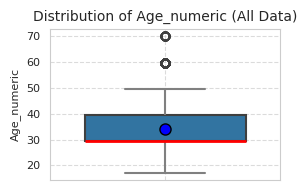

In [ ]:
# create boxplot for Age
create_grouped_boxplot(
    df=df,
    value_column='Age_numeric',
    group_column='all',
    cht_width=3,
    cht_height=2
)

In [ ]:
# check column EdLevel
print(show_value_counts(df, 'EdLevel'))

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          8629
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       5000
Some college/university study without earning a degree                                2456
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)    1143
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         661
Associate degree (A.A., A.S., etc.)                                                    634
Something else                                                                         190
Primary/elementary school                                                              132
Name: count, dtype: int64


In [ ]:
# Define the mapping for EdLevel simplification
edlevel_mapping = {
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'Bachelor',
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'Master',
    'Some college/university study without earning a degree': 'Non-deg college',
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'Secondary School',
    'Professional degree (JD, MD, Ph.D, Ed.D, etc.)': 'Professional Degree',
    'Associate degree (A.A., A.S., etc.)': 'Associate Degree',
    'Primary/elementary school': 'Primary School',
    'Something else': 'Others'
}

# Apply the mapping and fill NaN values
df['EdLevel_Simplified'] = df['EdLevel'].replace(edlevel_mapping).fillna('Others')

# Map 'Something else' to 'Others' if it's not already covered by fillna for original NaNs
df['EdLevel_Simplified'] = df['EdLevel_Simplified'].replace('Something else', 'Others')

print("Value counts for 'EdLevel_Simplified' column:")
print(df['EdLevel_Simplified'].value_counts(dropna=False))

Value counts for 'EdLevel_Simplified' column:
EdLevel_Simplified
Bachelor               8629
Master                 5000
Non-deg college        2456
Secondary School       1143
Professional Degree     661
Associate Degree        634
Others                  190
Primary School          132
Name: count, dtype: int64


/tmp/ipython-input-1200885393.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='EdLevel_Simplified',


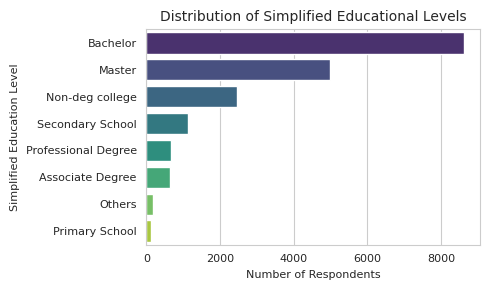

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(y='EdLevel_Simplified',
              data=df,
              order=df['EdLevel_Simplified'].value_counts().index,
              palette='viridis'
              )
plt.title('Distribution of Simplified Educational Levels', fontsize=10)
plt.xlabel('Number of Respondents', fontsize=8)
plt.ylabel('Simplified Education Level', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# To verify that new columns has been added
df.shape

(18845, 116)

In [ ]:
# Save df to df_cleaned.csv
df_cleaned=df.copy()
df.to_csv('df_cleaned.csv', index=False)
print("df_cleaned.csv saved")

df_cleaned.csv saved


### Horizontal Bar Chart for Top 10 Languages Developers Have Worked With

In [ ]:
# read this file and store it into df_LanguageHaveWorkedWith
df_LanguageHaveWorkedWith = pd.read_csv('LanguageHaveWorkedWith.csv')
print(df_LanguageHaveWorkedWith.head())

   ResponseId   LanguageHaveWorkedWith  age_numeric  JobSat
0           2  Bash/Shell (all shells)         39.5     NaN
1           2                       Go         39.5     NaN
2           2                 HTML/CSS         39.5     NaN
3           2                     Java         39.5     NaN
4           2               JavaScript         39.5     NaN


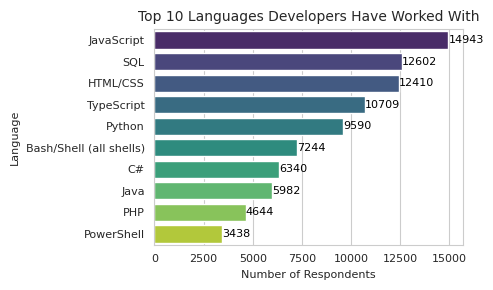

In [ ]:
# Get value counts for the 'LanguageHaveWorkedWith' column from the df_LanguageHaveWorkedWith DataFrame
language_counts = df_LanguageHaveWorkedWith['LanguageHaveWorkedWith'].value_counts().reset_index()
language_counts.columns = ['Language', 'Count']

# Select the top 10 languages
top_10_languages = language_counts.head(10)

plt.figure(figsize=(5, 3))
sns.barplot(x='Count', y='Language', data=top_10_languages, palette='viridis', hue='Language', legend=False)

# Add value labels at the end of each bar
for index, row in top_10_languages.iterrows():
    plt.text(row['Count'], index, f'{row['Count']}', color='black', ha='left', va='center', fontsize=8)

plt.title('Top 10 Languages Developers Have Worked With', fontsize=10)
plt.xlabel('Number of Respondents', fontsize=8)
plt.ylabel('Language', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

Horizontal Bar Chart for Top 10 Database Developers Have Worked With

In [ ]:
# read this file and store it into df_DatabaseHaveWorkedWith
df_DatabaseHaveWorkedWith = pd.read_csv('DatabaseHaveWorkedWith.csv')
print(df_DatabaseHaveWorkedWith.head())

   ResponseId      DatabaseHaveWorkedWith  age_numeric  JobSat
0           2                    Dynamodb         39.5     NaN
1           2                     MongoDB         39.5     NaN
2           2                  PostgreSQL         39.5     NaN
3           3  Firebase Realtime Database         49.5     NaN
4          10                     MongoDB         39.5     NaN


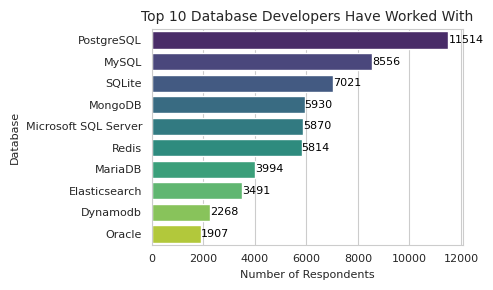

In [ ]:
# Get value counts for the 'DatabaseHaveWorkedWith' column from the df_DatabaseHaveWorkedWith DataFrame
Database_counts = df_DatabaseHaveWorkedWith['DatabaseHaveWorkedWith'].value_counts().reset_index()
Database_counts.columns = ['Database', 'Count']

# Select the top 10 Database
top_10_Database = Database_counts.head(10)

plt.figure(figsize=(5, 3))
sns.barplot(x='Count', y='Database', data=top_10_Database, palette='viridis', hue='Database', legend=False)

# Add value labels at the end of each bar
for index, row in top_10_Database.iterrows():
    plt.text(row['Count'], index, f'{row['Count']}', color='black', ha='left', va='center', fontsize=8)

plt.title('Top 10 Database Developers Have Worked With', fontsize=10)
plt.xlabel('Number of Respondents', fontsize=8)
plt.ylabel('Database', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

### Word Cloud for 'PlatformHaveWorkedWith'

This section generates a word cloud from the 'PlatformHaveWorkedWith' column to visually represent the most frequently mentioned platforms.

In [ ]:
# Read the dataset for word cloud
df=pd.read_csv('PlatformHaveWorkedWith.csv')
data_source_df = df

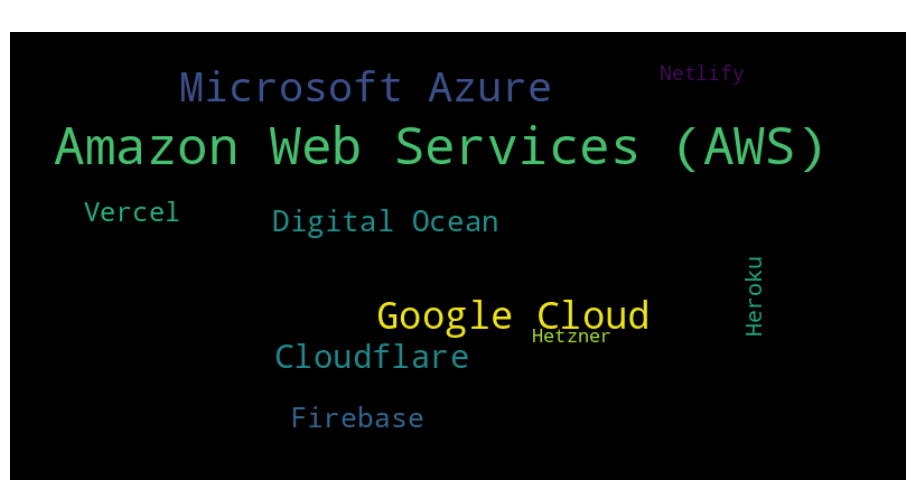

In [ ]:
from wordcloud import WordCloud
from collections import Counter

# Step 1: Extract and clean text
text = ';'.join(data_source_df['PlatformHaveWorkedWith'].dropna())

# Step 2: Count word frequencies
word_counts = Counter(text.split(';'))

# Step 3: Get top 10 words
top_10_words = dict(word_counts.most_common(10))

# Step 4: Generate word cloud with black background
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black'
).generate_from_frequencies(top_10_words)

# Step 5: Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Platforms Worked With', fontsize=12, color='white')
plt.tight_layout()
plt.show()



In [ ]:
# read this file and store it into df_WebFrameHaveWorkedWith
df_WebframeHaveWorkedWith = pd.read_csv('WebframeHaveWorkedWith.csv')
print(df_WebframeHaveWorkedWith.head())

   ResponseId WebframeHaveWorkedWith  age_numeric  JobSat
0           2                Express         39.5     NaN
1           2                Next.js         39.5     NaN
2           2                Node.js         39.5     NaN
3           2                  React         39.5     NaN
4           3           ASP.NET CORE         49.5     NaN


In [ ]:
# read this file and store it into df_LanguageWantToWorkWith
df_LanguageWantToWorkWith = pd.read_csv('LanguageWantToWorkWith.csv')
print(df_LanguageWantToWorkWith.head())

   ResponseId   LanguageWantToWorkWith  age_numeric  JobSat
0           2  Bash/Shell (all shells)         39.5     NaN
1           2                       Go         39.5     NaN
2           2                 HTML/CSS         39.5     NaN
3           2                     Java         39.5     NaN
4           2               JavaScript         39.5     NaN


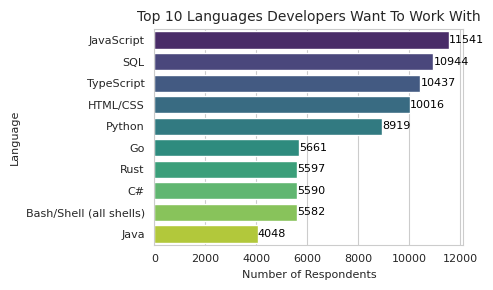

In [ ]:
# Get value counts for the 'df_LanguageWantToWorkWith' column from the df_LanguageWantToWorkWith DataFrame
language_counts = df_LanguageWantToWorkWith['LanguageWantToWorkWith'].value_counts().reset_index()
language_counts.columns = ['Language', 'Count']

# Select the top 10 languages
top_10_languages = language_counts.head(10)

plt.figure(figsize=(5, 3))
sns.barplot(x='Count', y='Language', data=top_10_languages, palette='viridis', hue='Language', legend=False)

# Add value labels at the end of each bar
for index, row in top_10_languages.iterrows():
    plt.text(row['Count'], index, f'{row['Count']}', color='black', ha='left', va='center', fontsize=8)

plt.title('Top 10 Languages Developers Want To Work With', fontsize=10)
plt.xlabel('Number of Respondents', fontsize=8)
plt.ylabel('Language', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# read this file and store it into df_DatabaseWantToWorkWith
df_DatabaseWantToWorkWith = pd.read_csv('DatabaseWantToWorkWith.csv')
print(df_DatabaseWantToWorkWith.head())

   ResponseId      DatabaseWantToWorkWith  age_numeric  JobSat
0           2                  PostgreSQL         39.5     NaN
1           3  Firebase Realtime Database         49.5     NaN
2          10                     MongoDB         39.5     NaN
3          10                       MySQL         39.5     NaN
4          10                  PostgreSQL         39.5     NaN


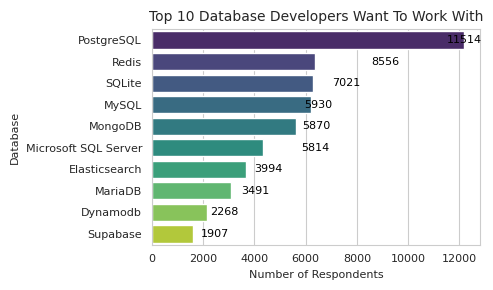

In [ ]:
# Get value counts for the 'df_DatabaseWantToWorkWith' column from the df_DatabaseWantToWorkWith DataFrame
language_counts = df_DatabaseWantToWorkWith['DatabaseWantToWorkWith'].value_counts().reset_index()
language_counts.columns = ['Database', 'Count']

# Select the top 10 languages
top_10_languages = language_counts.head(10)

plt.figure(figsize=(5, 3))
sns.barplot(x='Count', y='Database', data=top_10_languages, palette='viridis', hue='Database', legend=False)

# Add value labels at the end of each bar
for index, row in top_10_Database.iterrows():
    plt.text(row['Count'], index, f'{row['Count']}', color='black', ha='left', va='center', fontsize=8)

plt.title('Top 10 Database Developers Want To Work With', fontsize=10)
plt.xlabel('Number of Respondents', fontsize=8)
plt.ylabel('Database', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
# read this file and store it into df_PlatformWantToWorkWith
df_PlatformWantToWorkWith = pd.read_csv('PlatformWantToWorkWith.csv')
print(df_PlatformWantToWorkWith.head())

   ResponseId     PlatformWantToWorkWith  age_numeric  JobSat
0           2  Amazon Web Services (AWS)         39.5     NaN
1           2                     Heroku         39.5     NaN
2           2                    Netlify         39.5     NaN
3           3               Google Cloud         49.5     NaN
4          10  Amazon Web Services (AWS)         39.5     NaN


### Treemap for Top Platforms Developers Want To Work With

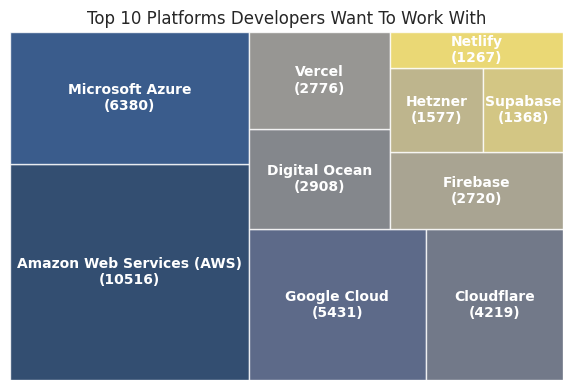

In [ ]:
import squarify # For treemap visualization

# Assuming df_PlatformWantToWorkWith is already loaded
# Get value counts for 'PlatformWantToWorkWith'
platform_counts = df_PlatformWantToWorkWith['PlatformWantToWorkWith'].value_counts().reset_index()
platform_counts.columns = ['Platform', 'Count']

# Select the top 10 platforms (you can adjust this number)
top_platforms = platform_counts.head(10)

# Prepare data for squarify
sizes = top_platforms['Count'].values
labels = top_platforms.apply(lambda x: f"{x['Platform']}\n({x['Count']})", axis=1)
colors = [plt.cm.cividis(i / float(len(labels))) for i in range(len(labels))] # Use cividis colormap

# Create the figure and axes
plt.figure(figsize=(6, 4))
ax = plt.gca()

# Create the treemap
squarify.plot(sizes=sizes,
              label=labels,
              color=colors,
              alpha=0.8,
              text_kwargs={'fontsize': 10, 'color': 'white', 'fontweight': 'bold'},
              ax=ax)

plt.title('Top 10 Platforms Developers Want To Work With', fontsize=12)
plt.axis('off') # Remove axes
plt.tight_layout()
plt.show()

# Create Bubble Chart for Web Framework Want To Work With

Prepare data fram

In [ ]:
# read the file
chk_column = 'WebframeHaveWorkedWith'
df_temp1 = pd.read_csv(chk_column + '.csv')  # Construct the filename using the correct saved format
print(df_temp1.head())

   ResponseId WebframeHaveWorkedWith  age_numeric  JobSat
0           2                Express         39.5     NaN
1           2                Next.js         39.5     NaN
2           2                Node.js         39.5     NaN
3           2                  React         39.5     NaN
4           3           ASP.NET CORE         49.5     NaN


In [ ]:
# Calculate the value_counts for the checking column
chk_counts = df_temp1[chk_column].value_counts()
chk_TopCnt = chk_counts.head(10).index.tolist()

print("Top 10 from List: ", chk_column)
print(chk_TopCnt)

Top 10 from List:  WebframeHaveWorkedWith
['Node.js', 'React', 'jQuery', 'Express', 'Next.js', 'ASP.NET CORE', 'Angular', 'Vue.js', 'ASP.NET', 'Spring Boot']


In [ ]:
# Make a copy of the df_cleaned DataFrame
df_expanded = df_cleaned.copy()

# Create a new column 'Webframe' by splitting chk_column
df_expanded = df_expanded.assign(
    Webframe=df_expanded[chk_column].apply(
        lambda x: str(x).split(';') if pd.notna(x) else []
    )
)

# Apply the .explode() method to the new 'Webframe' column
df_expanded = df_expanded.explode('Webframe')

# Remove any rows where the 'Webframe' column is empty or contains whitespace-only strings
df_expanded['Webframe'] = df_expanded['Webframe'].str.strip()
df_expanded = df_expanded[df_expanded['Webframe'] != ''].copy()

# Filter to include only rows where 'Webframe' is in 'top_10_webframes_want'
df_expanded = df_expanded[
    df_expanded['Webframe'].isin(chk_TopCnt)
].copy()

# Display the first few rows and check its shape
print("First 5 rows:")
display(df_expanded.head())

First 5 rows:


,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat,Age_numeric,EdLevel_Simplified,Webframe
0,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,39.5,Bachelor,Express
0,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,39.5,Bachelor,Next.js
0,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,39.5,Bachelor,Node.js
0,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,39.5,Bachelor,React
1,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN,49.5,Master,ASP.NET CORE


In [ ]:
df_metrics = df_expanded.groupby('Webframe').agg(
    Avg_ConvertedCompYearly=('ConvertedCompYearly', 'mean'),
    Unique_Respondents=('ResponseId', 'nunique')
).reset_index()

# Sort by Average ConvertedCompYearly in descending order
df_metrics = df_metrics.sort_values(by='Avg_ConvertedCompYearly', ascending=False)

print("First 5 rows:")
print(df_metrics.head())

First 5 rows:
       Webframe  Avg_ConvertedCompYearly  Unique_Respondents
6         React             84245.237140                8999
1  ASP.NET CORE             83988.072631                4319
7   Spring Boot             81540.725556                2916
5       Node.js             81294.313361                9230
4       Next.js             78616.699279                4399


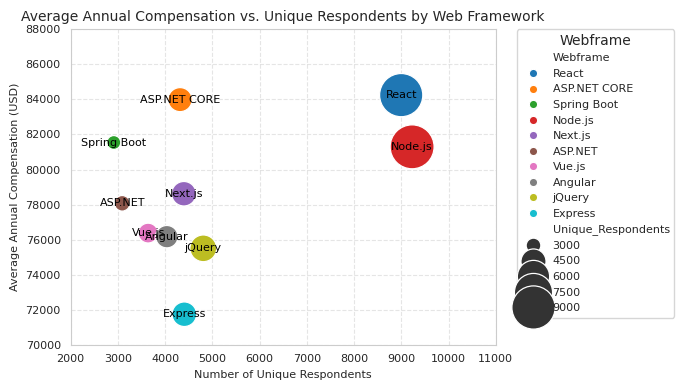

In [ ]:
# Create Bubble Chart on Average Annual Compensation vs Unique Respondents by Web Framework Have Worked WIth

plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=df_metrics,
    x='Unique_Respondents',
    y='Avg_ConvertedCompYearly',
    size='Unique_Respondents',  # Size of bubbles based on unique respondents
    sizes=(100, 1000),          # Range of bubble sizes
    hue='Webframe',             # Color based on webframe
    legend='brief',             # Show a brief legend
    palette='tab10'
)

# Add labels to each bubble
for i, row in df_metrics.iterrows():
    plt.text(
        row['Unique_Respondents'],
        row['Avg_ConvertedCompYearly'],
        row['Webframe'],
        ha='center',
        va='center',
        fontsize=8,
        color='black'
    )

plt.title('Average Annual Compensation vs. Unique Respondents by Web Framework', fontsize=10)
plt.xlabel('Number of Unique Respondents', fontsize=8)
plt.ylabel('Average Annual Compensation (USD)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(2000,11000)
plt.ylim(70000,88000)
plt.legend(fontsize=8, loc='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Webframe', fontsize=8) # Moved legend outside
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
df_metrics = df_expanded.groupby('Webframe').agg(
    Avg_ConvertedCompYearly=('ConvertedCompYearly', 'mean'),
    Avg_Age=('Age_numeric', 'mean')
).reset_index()

# Sort by Average ConvertedCompYearly in descending order
df_metrics = df_metrics.sort_values(by='Avg_ConvertedCompYearly', ascending=False)

print("First 5 rows:")
print(df_metrics.head())

First 5 rows:
       Webframe  Avg_ConvertedCompYearly    Avg_Age
6         React             84245.237140  32.347403
1  ASP.NET CORE             83988.072631  35.754000
7   Spring Boot             81540.725556  33.613036
5       Node.js             81294.313361  32.893155
4       Next.js             78616.699279  30.955538


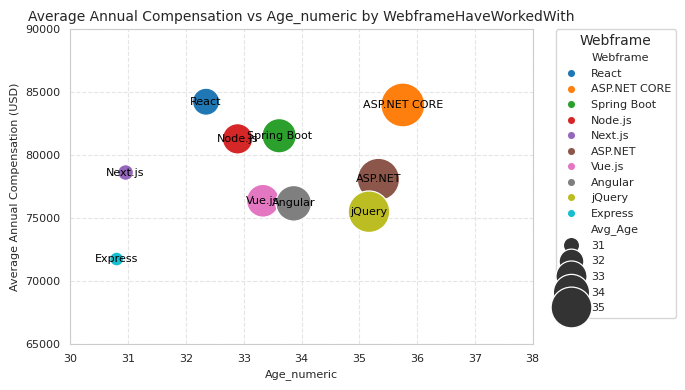

In [ ]:
# Create Bubble Chart on Average Annual Compensation vs Unique Respondents by Web Framework Have Worked WIth

plt.figure(figsize=(7, 4))
sns.scatterplot(
    data=df_metrics,
    x='Avg_Age',
    y='Avg_ConvertedCompYearly',
    size='Avg_Age',  # Size of bubbles based on unique respondents
    sizes=(100, 1000),          # Range of bubble sizes
    hue='Webframe',             # Color based on webframe
    legend='brief',             # Show a brief legend
    palette='tab10'
)

# Add labels to each bubble
for i, row in df_metrics.iterrows():
    plt.text(
        row['Avg_Age'],
        row['Avg_ConvertedCompYearly'],
        row['Webframe'],
        ha='center',
        va='center',
        fontsize=8,
        color='black'
    )

plt.title(f"Average Annual Compensation vs Age_numeric by {chk_column}", fontsize=10)
plt.xlabel('Age_numeric', fontsize=8)
plt.ylabel('Average Annual Compensation (USD)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(30,38)
plt.ylim(65000,90000)
plt.legend(fontsize=8, loc='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title='Webframe', fontsize=8) # Moved legend outside
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Horizontal Bar Chart for Median Annual Compensation by Simplified Educational Level

/tmp/ipython-input-4242417567.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_comp_by_edlevel = df_cleaned.groupby('EdLevel_Simplified')['ConvertedCompYearly'].median().reset_index()


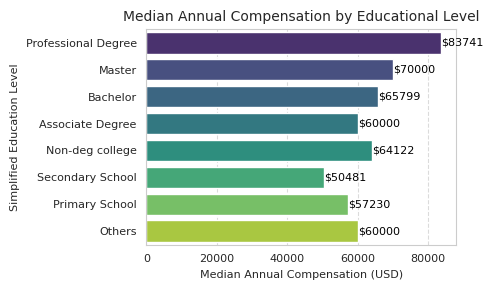

In [ ]:
# create the horizontal bar chart that EdLevel_Simplified in y-axis and median of ConvertedCompYearly in x-axis

df_cleaned = pd.read_csv('df_cleaned.csv')

# Define the desired order for EdLevel_Simplified
edlevel_order = [
    'Professional Degree',
    'Master',
    'Bachelor',
    'Associate Degree',
    'Non-deg college',
    'Secondary School',
    'Primary School',
    'Others'
]

# Convert 'EdLevel_Simplified' to a categorical type with the specified order
df_cleaned['EdLevel_Simplified'] = pd.Categorical(
    df_cleaned['EdLevel_Simplified'],
    categories=edlevel_order,
    ordered=True
)

# Calculate the median of 'ConvertedCompYearly' for each 'EdLevel_Simplified'
median_comp_by_edlevel = df_cleaned.groupby('EdLevel_Simplified')['ConvertedCompYearly'].median().reset_index()

# Sort the results by the defined categorical order
median_comp_by_edlevel = median_comp_by_edlevel.sort_values(by='EdLevel_Simplified', ascending=False)

plt.figure(figsize=(5, 3))
sns.barplot(
    x='ConvertedCompYearly',
    y='EdLevel_Simplified',
    data=median_comp_by_edlevel,
    palette='viridis',
    hue='EdLevel_Simplified',
    legend=False
)

# Add value labels at the end of each bar
for index, row in median_comp_by_edlevel.iterrows():
    plt.text(row['ConvertedCompYearly'], index, f'${row['ConvertedCompYearly']:.0f}', color='black', ha='left', va='center', fontsize=8)

plt.title('Median Annual Compensation by Educational Level', fontsize=10)
plt.xlabel('Median Annual Compensation (USD)', fontsize=8)
plt.ylabel('Simplified Education Level', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Pie Chart for Respondent Distribution by Age

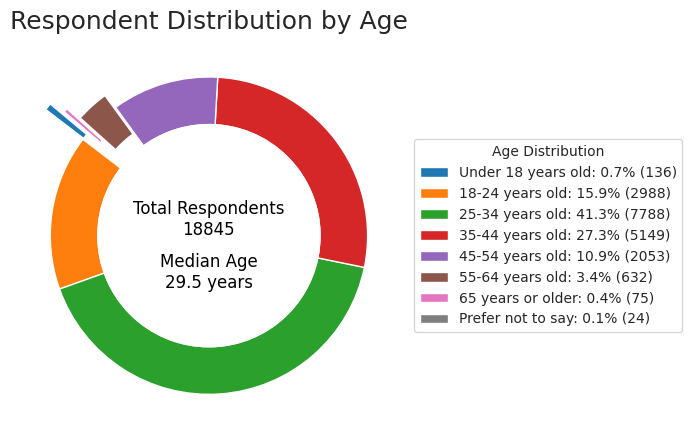

In [ ]:
# Assuming df_cleaned is already loaded from 'df_cleaned.csv' or available in the session
df_cleaned = pd.read_csv('df_cleaned.csv')

# Define the desired order for Age categories
age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older',
    'Prefer not to say'
]

# Convert 'Age' column to a categorical type with the specified order
df_cleaned['Age'] = pd.Categorical(
    df_cleaned['Age'],
    categories=age_order,
    ordered=True
)

# Calculate value counts for the 'Age' column and sort them by the defined order
age_distribution = df_cleaned['Age'].value_counts().sort_index()

plt.figure(figsize=(7, 7)) # Adjusted figure size to make space for legend

def autopct_format_legend(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f'{pct:.1f}% ({absolute})'

# Define explode for smaller slices to prevent overlap
explode = [0.3, 0, 0, 0, 0, 0.1, 0.2, 0.3] # Corresponding to age_order

wedges, texts = plt.pie(
    age_distribution,
    startangle=140,
    wedgeprops=dict(width=0.3),
    explode=explode
)

# Draw a white circle in the middle to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Calculate total respondents and median age
total_respondents = df_cleaned.shape[0]
median_age = df_cleaned['Age_numeric'].median() # Assuming 'Age_numeric' column exists

# Add text in the center of the donut
plt.text(0, 0.1, f'Total Respondents\n{total_respondents}',
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')
plt.text(0, -0.1, f'\n\nMedian Age\n{median_age:.1f} years',
         horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')

# Create a custom legend with labels and values
legend_labels = []
for i, (label, value) in enumerate(zip(age_distribution.index, age_distribution.values)):
    pct = (value / sum(age_distribution.values)) * 100
    legend_labels.append(f'{label}: {autopct_format_legend(pct, age_distribution.values)}')

plt.legend(wedges, legend_labels,
           title="Age Distribution",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Respondent Distribution by Age', fontsize=18)
plt.tight_layout()
plt.show()

### Horizontal Boxplot Chart for Annual Compensation by Simplified Educational Level

/tmp/ipython-input-4192544194.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


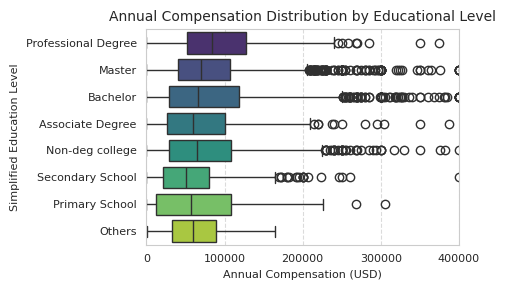

In [ ]:
# Define the desired order for EdLevel_Simplified
edlevel_order = [
    'Professional Degree',
    'Master',
    'Bachelor',
    'Associate Degree',
    'Non-deg college',
    'Secondary School',
    'Primary School',
    'Others'
]

# Convert 'EdLevel_Simplified' to a categorical type with the specified order
df_cleaned['EdLevel_Simplified'] = pd.Categorical(
    df_cleaned['EdLevel_Simplified'],
    categories=edlevel_order,
    ordered=True
)

plt.figure(figsize=(5, 3))
sns.boxplot(
    x='ConvertedCompYearly',
    y='EdLevel_Simplified',
    data=df_cleaned.dropna(subset=['ConvertedCompYearly']),
    palette='viridis',
    orient='h' # This makes the boxplot horizontal
)

plt.title('Annual Compensation Distribution by Educational Level', fontsize=10)
plt.xlabel('Annual Compensation (USD)', fontsize=8)
plt.ylabel('Simplified Education Level', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim(0, 400000)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Stacked Horizontal Bar Chart for Respondent Count by Age, Grouped by Simplified Educational Level

/tmp/ipython-input-805031543.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stacked_data = df_cleaned.groupby(['Age', 'EdLevel_Simplified']).size().unstack(fill_value=0)


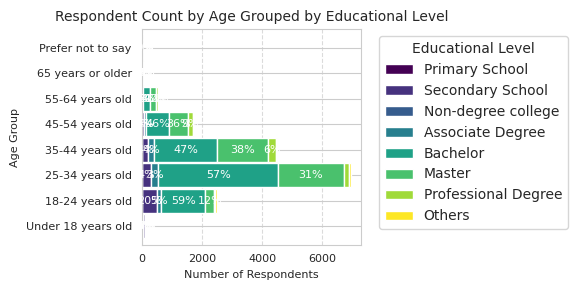

In [ ]:
# Define the desired order for EdLevel_Simplified
edlevel_order = [
    'Primary School',
    'Secondary School',
    'Non-degree college',
    'Associate Degree',
    'Bachelor',
    'Master',
    'Professional Degree',
    'Others'
]

# Define the desired order for Age categories
age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older',
    'Prefer not to say'
]

# Convert 'EdLevel_Simplified' to a categorical type with the specified order
df_cleaned['EdLevel_Simplified'] = pd.Categorical(
    df_cleaned['EdLevel_Simplified'],
    categories=edlevel_order,
    ordered=True
)

# Convert 'Age' column to a categorical type with the specified order
df_cleaned['Age'] = pd.Categorical(
    df_cleaned['Age'],
    categories=age_order,
    ordered=True
)

# Group by Age and EdLevel_Simplified and count respondents
stacked_data = df_cleaned.groupby(['Age', 'EdLevel_Simplified']).size().unstack(fill_value=0)

# Calculate percentages for labeling
stacked_data_percentage = stacked_data.div(stacked_data.sum(axis=1), axis=0) * 100

# Plotting the stacked horizontal bar chart
ax = stacked_data.plot(kind='barh', stacked=True, figsize=(6, 3), cmap='viridis', width=0.95) # Made bars wider with width=0.95

# Add percentage labels
for i, total_row_sum in enumerate(stacked_data.sum(axis=1)):
    current_x = 0
    for j, col_name in enumerate(stacked_data.columns):
        value = stacked_data.iloc[i, j]
        percentage = stacked_data_percentage.iloc[i, j]

        if percentage > 3: # Only label segments larger than 3% to avoid clutter
            ax.text(current_x + value / 2, # x position for text (center of the segment)
                    i,                       # y position for text (center of the bar)
                    f'{percentage:.0f}%',   # The text
                    va='center',             # Vertical alignment
                    ha='center',             # Horizontal alignment
                    color='white',           # Text color
                    fontsize=8)              # Text fontsize

        current_x += value # Update x-position for the next segment


plt.title('Respondent Count by Age Grouped by Educational Level', fontsize=10)
plt.xlabel('Number of Respondents', fontsize=8)
plt.ylabel('Age Group', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(title='Educational Level', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Line Chart for Respondent Count by Age, Grouped by Simplified Educational Level

In [ ]:
# Define the desired order for EdLevel_Simplified
edlevel_order = [
    'Primary School',
    'Secondary School',
    'Non-degree college',
    'Associate Degree',
    'Bachelor',
    'Master',
    'Professional Degree',
    'Others'
]

# Define the desired order for Age categories
age_order = [
    'Under 18 years old',
    '18-24 years old',
    '25-34 years old',
    '35-44 years old',
    '45-54 years old',
    '55-64 years old',
    '65 years or older',
    'Prefer not to say'
]

# Convert 'EdLevel_Simplified' and 'Age' columns to categorical types with the specified orders
df_cleaned['EdLevel_Simplified'] = pd.Categorical(
    df_cleaned['EdLevel_Simplified'],
    categories=edlevel_order,
    ordered=True
)
df_cleaned['Age'] = pd.Categorical(
    df_cleaned['Age'],
    categories=age_order,
    ordered=True
)

# Group by Age and EdLevel_Simplified and count respondents
age_edlevel_counts = df_cleaned.groupby(['Age', 'EdLevel_Simplified']).size().reset_index(name='Respondent_Count')

# Create the line chart
fig = px.line(
    age_edlevel_counts,
    x='Age',
    y='Respondent_Count',
    color='EdLevel_Simplified',
    title='Respondent Count by Age Grouped by Educational Level',
    labels={
        'Age': 'Age Group',
        'Respondent_Count': 'Number of Respondents',
        'EdLevel_Simplified': 'Educational Level'
    },
    line_shape='linear', # or 'spline'
    markers=True,
    height=500, # Adjust height as needed
    width=800 # Adjust width as needed
)

fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': age_order},
    legend_title_text='Educational Level',
    hovermode='x unified',
    title_font_size=16 # Adjust the title font size here
)

# Add annotations for values > 500
for index, row in age_edlevel_counts.iterrows():
    if row['Respondent_Count'] > 500:
        fig.add_annotation(
            x=row['Age'],
            y=row['Respondent_Count'],
            text=str(row['Respondent_Count']),
            showarrow=False,
            yshift=10, # Shift text slightly above the marker
            font=dict(size=10, color='black') # Adjust font size and color if needed
        )

fig.show()

/tmp/ipython-input-471510365.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_edlevel_counts = df_cleaned.groupby(['Age', 'EdLevel_Simplified']).size().reset_index(name='Respondent_Count')


# **World Map to indicate Respondent Count by country**

In [ ]:
# Group by 'Country' and count unique 'ResponseId's
country_respondent_counts = df_cleaned.groupby('Country')['ResponseId'].nunique().reset_index()

# Rename the count column to 'Respondent_Count'
country_respondent_counts.columns = ['Country', 'Respondent_Count']

# Sort the results by 'Respondent_Count' in descending order to easily see top countries
country_respondent_counts = country_respondent_counts.sort_values(by='Respondent_Count', ascending=False)

# Display the first few rows and the shape of the resulting DataFrame
print("First 5 rows of country_respondent_counts:")
print(country_respondent_counts.head())
print("\nShape of country_respondent_counts:", country_respondent_counts.shape)

First 5 rows of country_respondent_counts:
                                               Country  Respondent_Count
153                           United States of America              3441
53                                             Germany              1339
62                                               India              1316
151  United Kingdom of Great Britain and Northern I...              1053
149                                            Ukraine               931

Shape of country_respondent_counts: (161, 2)


In [ ]:

# Create a choropleth map
fig = px.choropleth(
    country_respondent_counts,
    locations="Country",
    locationmode="country names", # Specify how locations are identified
    color="Respondent_Count",
    hover_name="Country",
    color_continuous_scale=px.colors.sequential.Reds, # Use a red color scale
    title="World Map of Stack Overflow Survey Respondent Distribution by Country",
    height=500 # Set plot height for better visibility
)

# Update layout for better presentation
fig.update_layout(
    title_x=0.5, # Center the title
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='natural earth' # Use a natural earth projection
    )
)

fig.show()


# **Download csv files to local drive**

In [ ]:
def download_multiple_csv_files(filenames_to_download):

    print("Initiating download for the following files:")
    for filename in filenames_to_download:
        full_path = os.path.join('/content/', filename)

        if os.path.exists(full_path):
            try:
                files.download(full_path)
                print(f"  - '{filename}' download initiated.")
            except Exception as e:
                print(f"  - Error downloading '{filename}': {e}")
        else:
            print(f"  - Error: '{filename}' not found at {full_path}. Please ensure it exists by re-running the creation cell if needed.")

    print("\nAll download attempts have been initiated. Check your browser for prompts.")

# Example usage for the individual item CSVs we created:
columns_to_download_base = [
    'LanguageHaveWorkedWith',
    'DatabaseHaveWorkedWith',
    'PlatformHaveWorkedWith',
    'WebframeHaveWorkedWith',
    'LanguageWantToWorkWith',
    'DatabaseWantToWorkWith',
    'PlatformWantToWorkWith',
    'WebframeWantToWorkWith'
]

# Construct the full filenames as they were saved
csv_files_to_download = [f'{col_name}.csv' for col_name in columns_to_download_base]

# You might also want to download df_cleaned.csv and the bubble chart data csv
csv_files_to_download.append('df_cleaned.csv')
csv_files_to_download.append('Webframe_Age_Compensation_Bubble_Data.csv') # Previous bubble chart data
csv_files_to_download.append('Top10_WebFrameWant_AgeComp_BubbleData_New.csv') # Latest bubble chart data

# Call the function to download the files
download_multiple_csv_files(csv_files_to_download)

Initiating download for the following files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'LanguageHaveWorkedWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'DatabaseHaveWorkedWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'PlatformHaveWorkedWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'WebframeHaveWorkedWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'LanguageWantToWorkWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'DatabaseWantToWorkWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'PlatformWantToWorkWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'WebframeWantToWorkWith.csv' download initiated.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  - 'df_cleaned.csv' download initiated.
  - Error: 'Webframe_Age_Compensation_Bubble_Data.csv' not found at /content/Webframe_Age_Compensation_Bubble_Data.csv. Please ensure it exists by re-running the creation cell if needed.
  - Error: 'Top10_WebFrameWant_AgeComp_BubbleData_New.csv' not found at /content/Top10_WebFrameWant_AgeComp_BubbleData_New.csv. Please ensure it exists by re-running the creation cell if needed.

All download attempts have been initiated. Check your browser for prompts.
